In [34]:
import warnings
warnings.filterwarnings('ignore')

https://arxiv.org/pdf/2308.04419.pdf

In [35]:
import yfinance as yf
import pandas as pd
import numpy as np

In [36]:
input_length = 1
target_length = 30

In [37]:
# AAPL hisse senedi sembolü
symbol = "AAPL"

# Tarih aralığını belirleyin (örneğin, son 1 yıl)
start_date = "2022-01-01"
end_date = "2023-01-01"

period = "5y"
interval = "1d"

# Verileri çek
# data = yf.download(symbol, start=start_date, end=end_date)
data = yf.download(symbol, period=period, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [38]:
# Veriyi göster
print(data.head())

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-01-22  39.102501  39.182499  38.154999  38.325001  36.784756  121576000
2019-01-23  38.537498  38.785000  37.924999  38.480000  36.933517   92522400
2019-01-24  38.527500  38.619999  37.935001  38.174999  36.640778  101766000
2019-01-25  38.869999  39.532501  38.580002  39.439999  37.854939  134142000
2019-01-28  38.947498  39.082500  38.415001  39.075001  37.504616  104768400


In [39]:
data['Target'] = data['Close'].shift(-target_length)
data.drop('Adj Close', axis=1, inplace=True)
data = data.dropna()
print(data.head(5))

                 Open       High        Low      Close     Volume     Target
Date                                                                        
2019-01-22  39.102501  39.182499  38.154999  38.325001  121576000  43.630001
2019-01-23  38.537498  38.785000  37.924999  38.480000   92522400  43.125000
2019-01-24  38.527500  38.619999  37.935001  38.174999  101766000  43.227501
2019-01-25  38.869999  39.532501  38.580002  39.439999  134142000  44.724998
2019-01-28  38.947498  39.082500  38.415001  39.075001  104768400  45.227501


In [40]:
def calculate_adx_di(df, len_param=14):
    """
    Verilen bir DataFrame'e ADX ve DIPlus, DIMinus sütunlarını ekleyen fonksiyon.

    Parameters:
    - df: DataFrame, Hissedarlık verilerini içeren DataFrame.
    - len_param: int, SmoothedTrueRange ve ADX hesaplamak için kullanılacak periyot.

    Returns:
    - df: DataFrame, Güncellenmiş DataFrame.
    """

    # TrueRange hesaplama
    df['TrueRange'] = df.apply(lambda row: max(row['High'] - row['Low'], abs(row['High'] - df['Close'].shift(1)[row.name]), abs(row['Low'] - df['Close'].shift(1)[row.name])), axis=1)

    # Directional Movement hesaplama
    df['DirectionalMovementPlus'] = df.apply(lambda row: max(row['High'] - df['High'].shift(1)[row.name], 0) if row['High'] - df['High'].shift(1)[row.name] > df['Low'].shift(1)[row.name] - row['Low'] else 0, axis=1)
    df['DirectionalMovementMinus'] = df.apply(lambda row: max(df['Low'].shift(1)[row.name] - row['Low'], 0) if df['Low'].shift(1)[row.name] - row['Low'] > row['High'] - df['High'].shift(1)[row.name] else 0, axis=1)

    # # Smoothed TrueRange ve Directional Movement hesaplama
    df['SmoothedTrueRange'] = 0.0
    df['SmoothedDirectionalMovementPlus'] = 0.0
    df['SmoothedDirectionalMovementMinus'] = 0.0

    for i in range(1, len(df)):
        df.at[df.index[i], 'SmoothedTrueRange'] = df.at[df.index[i-1], 'SmoothedTrueRange'] - (df.at[df.index[i-1], 'SmoothedTrueRange'] / len_param) + df.at[df.index[i], 'TrueRange']
        df.at[df.index[i], 'SmoothedDirectionalMovementPlus'] = df.at[df.index[i-1], 'SmoothedDirectionalMovementPlus'] - (df.at[df.index[i-1], 'SmoothedDirectionalMovementPlus'] / len_param) + df.at[df.index[i], 'DirectionalMovementPlus']
        df.at[df.index[i], 'SmoothedDirectionalMovementMinus'] = df.at[df.index[i-1], 'SmoothedDirectionalMovementMinus'] - (df.at[df.index[i-1], 'SmoothedDirectionalMovementMinus'] / len_param) + df.at[df.index[i], 'DirectionalMovementMinus']

    # DIPlus, DIMinus ve ADX hesaplama
    df['DIPlus'] = df['SmoothedDirectionalMovementPlus'] / df['SmoothedTrueRange'] * 100
    df['DIMinus'] = df['SmoothedDirectionalMovementMinus'] / df['SmoothedTrueRange'] * 100
    df['DX'] = abs(df['DIPlus'] - df['DIMinus']) / (df['DIPlus'] + df['DIMinus']) * 100
    df['ADX'] = df['DX'].rolling(window=len_param).mean()

    # Gereksiz sütunları düşürme
    df = df.drop(['TrueRange', 'DirectionalMovementPlus', 'DirectionalMovementMinus', 'SmoothedTrueRange', 'SmoothedDirectionalMovementPlus', 'SmoothedDirectionalMovementMinus', 'DX'], axis=1)

    # İlk 14 satırın NaN değerlerini temizleme
    df = df.dropna()

    return df

data = calculate_adx_di(data)

In [41]:
X = data[['Open', 'High', 'Low', 'Close', 'Volume', 'DIPlus', 'DIMinus', 'ADX']].values
# X = data[['Open', 'High', 'Low', 'Close', 'Volume']].values

In [42]:
data.tail()

cols = data.columns
inds = data.index

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
# data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

In [44]:
y = data[['Close']].values

In [45]:
# define the size of the training set
train_size = int(len(data) * 0.8)

train, test = data.iloc[:train_size, :], data.iloc[train_size:, :]

In [46]:
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset.drop(['Target'], axis=1).iloc[i:(i+time_steps), :].values
        X.append(a)
        y.append(dataset.iloc[i, 5])
    return np.array(X), np.array(y).reshape(-1, 1)

In [47]:
X_train, y_train = create_dataset(train, input_length)
X_test, y_test = create_dataset(test, input_length)

In [48]:
# split the data into training and testing sets
X_train, X_test = X[:train_size, :], X[train_size:, :]
y_train, y_test = y[:train_size], y[train_size:]

In [49]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(971, 8)
(971, 1)
(243, 8)
(243, 1)


In [50]:
from sklearn.preprocessing import MinMaxScaler

# # normalize the data using MinMaxScaler
# X_scaler = MinMaxScaler(feature_range=(0, 1))
# y_scaler = MinMaxScaler(feature_range=(0, 1))
# 
# X_train = X_scaler.fit_transform(X_train)
# y_train = y_scaler.fit_transform(y_train)
# 
# X_test = X_scaler.transform(X_test)
# y_test = y_scaler.transform(y_test)

# Eğitim ve test setlerini göster
print("Eğitim seti:", X_train.shape, y_train.shape)
print("Test seti:", X_test.shape, y_test.shape)

Eğitim seti: (971, 8) (971, 1)
Test seti: (243, 8) (243, 1)


In [51]:
# reshape the input data into 3D format (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [52]:
# Eğitim ve test setlerini göster
print("Eğitim seti:", X_train.shape, y_train.shape)
print("Test seti:", X_test.shape, y_test.shape)

Eğitim seti: (971, 1, 8) (971, 1)
Test seti: (243, 1, 8) (243, 1)


In [53]:
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense

# define the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 100)            43600     
                                                                 
 dropout_3 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_4 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [55]:
# train the model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

model_his = model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpoint])

Epoch 1/10


233/243 [===========================>..] - ETA: 0s - loss: 94.7382
Epoch 1: val_loss improved from inf to 138.53761, saving model to best_model.h5
243/243 [==============================] - 6s 8ms/step - loss: 94.5862 - val_loss: 138.5376
Epoch 2/10
235/243 [============================>.] - ETA: 0s - loss: 72.1729
Epoch 2: val_loss improved from 138.53761 to 119.59119, saving model to best_model.h5
243/243 [==============================] - 1s 4ms/step - loss: 72.1483 - val_loss: 119.5912
Epoch 3/10
235/243 [============================>.] - ETA: 0s - loss: 58.4463
Epoch 3: val_loss improved from 119.59119 to 105.92062, saving model to best_model.h5
243/243 [==============================] - 1s 4ms/step - loss: 58.4538 - val_loss: 105.9206
Epoch 4/10
238/243 [============================>.] - ETA: 0s - loss: 51.2587
Epoch 4: val_loss improved from 105.92062 to 94.85057, saving model to best_model.h5
243/243 [==============================] - 1s 5ms/step - loss: 51.1755 - val_loss: 94.

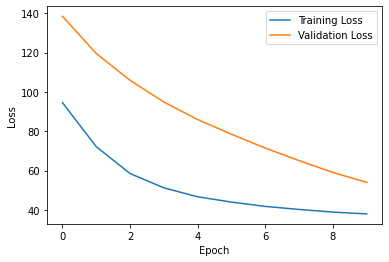

In [56]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(model_his.history['loss'], label='Training Loss')
plt.plot(model_his.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
preds = model.predict(X_test)

In [58]:
# inverse transform eklenecek

In [59]:
# min_values = scaler.data_min_
# max_values = scaler.data_max_
# data_range = scaler.data_range_

AttributeError: 'MinMaxScaler' object has no attribute 'data_min_'

In [60]:
import matplotlib.pyplot as plt
import numpy as np

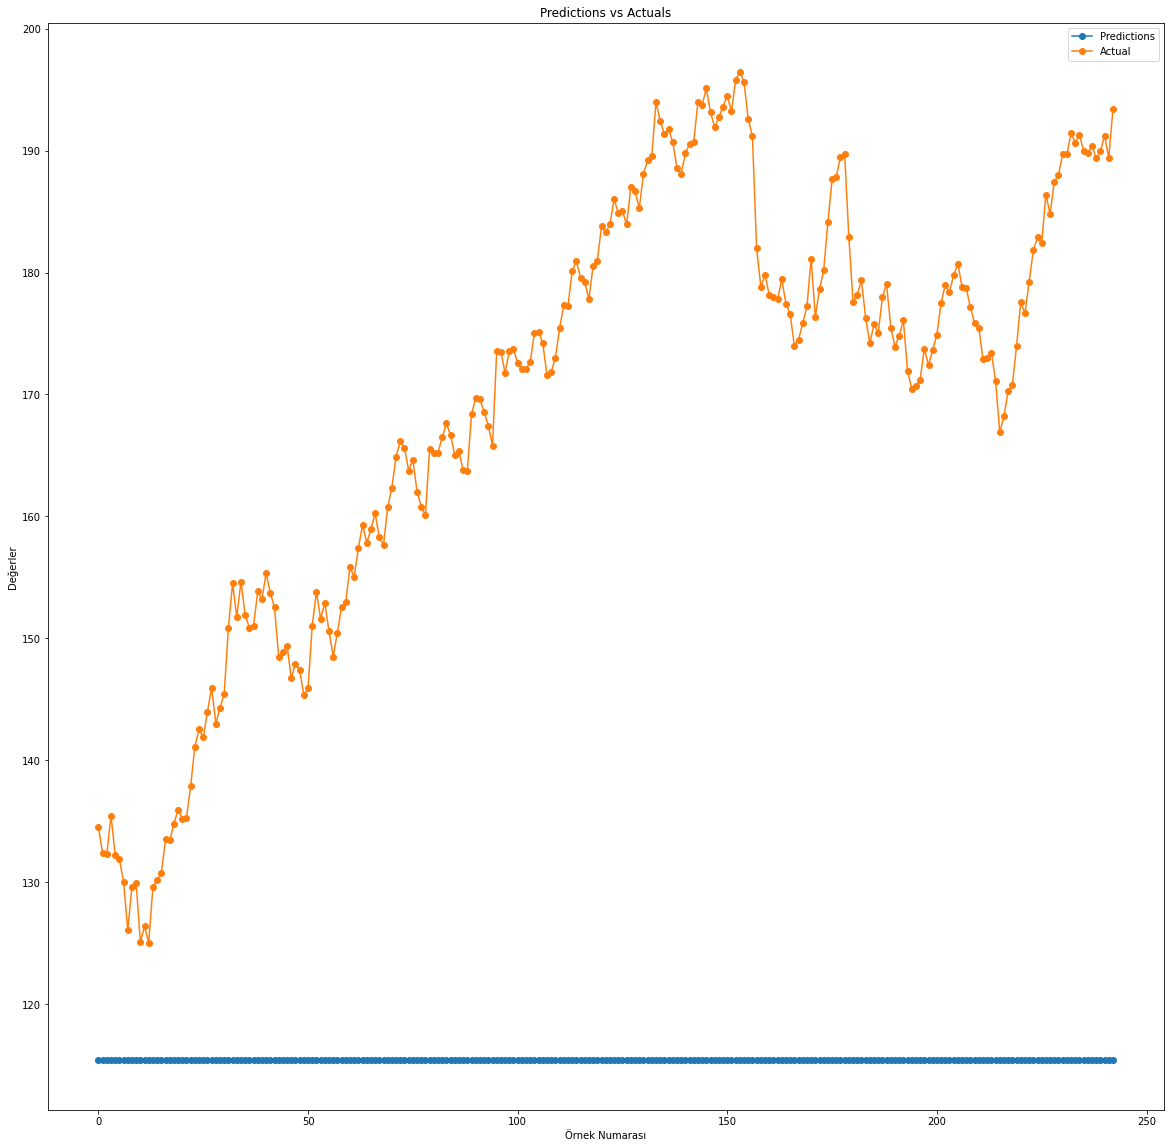

In [61]:
# X eksenindeki değerler
x_values = np.arange(len(preds))


plt.figure(figsize=(20, 20))


# Çizgi grafikleri oluştur
plt.plot(x_values, preds, label='Predictions', marker='o')
plt.plot(x_values, y_test, label='Actual', marker='o')

# Eksen etiketleri
plt.xlabel('Örnek Numarası')
plt.ylabel('Değerler')

# Başlık
plt.title('Predictions vs Actuals')

# İlgili yeri göster
plt.legend()

plt.savefig('example_plot.png')

# Grafik göster
plt.show()

In [62]:
from sklearn.metrics import mean_absolute_error as mae

# calculate MAE 
error = mae(preds, y_test) 
  
# display 
print("Mean absolute error : " + str(error)) 

Mean absolute error : 53.930113647209765


In [63]:
from sklearn.metrics import mean_absolute_percentage_error

error = mean_absolute_percentage_error(preds, y_test)
print("Mean absolute error : " + str(error)) 

Mean absolute error : 0.4674606588484457


In [64]:
for index, value in enumerate(preds):
    print(value, y_test[index])

[115.36824] [134.50999451]
[115.36824] [132.36999512]
[115.36824] [132.30000305]
[115.36824] [135.44999695]
[115.36824] [132.22999573]
[115.36824] [131.86000061]
[115.36824] [130.02999878]
[115.36824] [126.04000092]
[115.36824] [129.61000061]
[115.36824] [129.92999268]
[115.36824] [125.06999969]
[115.36824] [126.36000061]
[115.36824] [125.01999664]
[115.36824] [129.61999512]
[115.36824] [130.1499939]
[115.36824] [130.72999573]
[115.36824] [133.49000549]
[115.36824] [133.41000366]
[115.36824] [134.75999451]
[115.36824] [135.94000244]
[115.36824] [135.21000671]
[115.36824] [135.27000427]
[115.36824] [137.86999512]
[115.36824] [141.11000061]
[115.36824] [142.52999878]
[115.36824] [141.86000061]
[115.36824] [143.96000671]
[115.36824] [145.92999268]
[115.36824] [143.]
[115.36824] [144.28999329]
[115.36824] [145.42999268]
[115.36824] [150.82000732]
[115.36824] [154.5]
[115.36824] [151.72999573]
[115.36824] [154.6499939]
[115.36824] [151.91999817]
[115.36824] [150.86999512]
[115.36824] [151.0